In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle
def save_results_to_file(result_dict,name):
    with open(name+'.pkl', 'wb') as fp:
        pickle.dump(result_dict, fp)   
def read_results_from_file(name):
    with open(name+'.pkl', 'rb') as fp:
        res = pickle.load(fp)   
    return res

def plot_histogram(data,numberofbins,label,minimum,maximum):
    bins = np.linspace(minimum, maximum, numberofbins)
    bin_probabilities = np.histogram(data,bins)[0]/len(data)
    leftedges = bins[:-1]
    rightedges = bins[1:]
    widths = np.array(rightedges)-np.array(leftedges)
    plt.bar(leftedges,bin_probabilities,width=widths,align='edge',label=label,alpha=0.5)
    binmidvalues = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
def plot_with_error(results,which_data,title):
    plt.figure(figsize=(16, 8))
    means = np.mean(results[which_data],axis=0)
    plt.plot(range(len(means)),means,label='Means')
    stdevs = np.std(results[which_data],axis=0)
    plt.fill_between(range(len(means)), means-stdevs, means+stdevs,alpha=0.5,label='Variance')
    plt.legend()
    plt.title(title)

In [2]:
def monthly_mortgage_calculator(principal,monthly_rate,total_loan_months = 20*12):
    if principal<=0:
        return 0
    numerator = principal*monthly_rate*((1+monthly_rate)**total_loan_months)
    denominator = ((1+monthly_rate)**total_loan_months - 1)
    return numerator/denominator

def outstanding_loan_balance(principal,monthly_rate,total_loan_months,months_paid):
    numerator = principal*( (1+monthly_rate)**total_loan_months - (1+monthly_rate)**months_paid )
    denominator = ((1+monthly_rate)**total_loan_months - 1)
    return numerator/denominator

class House(object):
    def __init__(self,price,house_type,monthly_rate,initial_paid,loan_months = 20*12):
        self.house_type = house_type
        self.price = price
        self.initial_paid = initial_paid
        self.monthly_rate = monthly_rate
        self.loan_amount = price-initial_paid
        self.loan_principal_left = price-initial_paid
        self.loan_months = loan_months
        self.months_paid = 0
        self.monthly_repayment = monthly_mortgage_calculator(price-initial_paid,monthly_rate,loan_months)
    def finish_paid(self):
        if self.months_paid == self.loan_months:
            return True
        else:
            return False
    def pay_loan(self):
        if self.finish_paid() == False:
            self.months_paid = self.months_paid + 1
            self.loan_principal_left = outstanding_loan_balance(self.loan_amount,self.monthly_rate,self.loan_months,self.months_paid)
    def get_house_type(self):
        return self.house_type
    def monthly_repayments(self):
        if self.finish_paid() == True:
            return 0
        else:
            return self.monthly_repayment
    def get_original_price(self):
        return self.price
    def get_outstanding_loan_principal(self):
        return self.loan_principal_left
    
def makes_sense_to_sell(house,current_resale_price,rental_price):
    if house.monthly_repayments()<=rental_price:#Check if rentals cover monthly repayments
        return False
    else:
        if house.get_original_price()<current_resale_price:#Check if will make profit
            return True
        else:
            return False
        
class Person(object):
    def __init__(self,salary):
        self.salary = salary
        self.savings = 0
        self.HDB_properties = []
        self.condo_properties = []
        self.agent_type = 1 #1: Household no property, 2: Household with HDB no condo, 3: Household with single condo, 4: Household with multiple property
        self.selling_HDB = False
        self.selling_condo = False
        self.buying_HDB = False
        self.buying_condo = False
    def owns_HDB(self):
        if len(self.HDB_properties) == 0:
            return False
        else:
            return True
    def get_savings(self):
        return self.savings
    def owns_condo(self):
        if len(self.condo_properties) == 0:
            return False
        else:
            return True
    def add_HDB(self,the_HDB):
        if self.owns_HDB() == True:
            raise Exception('Cannot add HDB to someone already owning HDB')
        elif self.owns_condo() == True:
            raise Exception('Cannot add HDB to someone owning condo')
        elif the_HDB.get_house_type() != 'HDB':
            raise Exception('This is not a HDB!')
        else:
            self.HDB_properties.append(the_HDB)
            self.admin_update_agent_type()
            self.buying_HDB = False
            self.buying_condo = False
    def add_condo(self,the_condo):
        if the_condo.get_house_type() != 'condo':
            raise Exception('This is not a condo!')
        else:
            self.condo_properties.append(the_condo)
            self.buying_HDB = False
            self.buying_condo = False
    def count_property(self):
        return len(self.HDB_properties)+len(self.condo_properties)
    def calculate_income(self,rental_price):
        income = self.salary
        expenses = 0
        if self.count_property()==0:
            return income
        else:
            for a in self.HDB_properties:
                expenses = expenses + a.monthly_repayments()
            for a in self.condo_properties:
                expenses = expenses + a.monthly_repayments()
            if self.count_property()>1:
                income = income + (self.count_property()-1)*rental_price
            return income-expenses
    def make_decisions(self,HDB_price,condo_price,rental_price,monthly_mortgage_rate):
        #agent_type 2: Check if can afford to buy a resale condo without selling. 
        #Then, check if can afford to buy a resale condo with selling HDB
        self.selling_HDB = False
        self.selling_condo = False
        self.buying_HDB = False
        self.buying_condo = False
        if self.agent_type == 2:
            #Only buy or sell if not in debt
            if self.savings >=0:
                if monthly_mortgage_calculator(condo_price-self.savings,monthly_mortgage_rate)<rental_price:#Rental covers mortgage
                    # print('Buying 2')
                    self.buying_condo = True
                else:
                    if monthly_mortgage_calculator(condo_price-HDB_price-self.savings,monthly_mortgage_rate)<self.salary:#Can afford to upgrade to condo by selling HDB
                        #This happens in 2 steps tho, in this first step agent sells HDB
                        # print('Upgrader')
                        self.selling_HDB = True
                    #Else does nothing

        elif self.agent_type == 1:#Potential buyer for both HDB and condo
            #Only buy or sell if not in debt
            if self.savings >=0:
                self.buying_condo = True
                self.buying_HDB = True
        elif self.agent_type == 3:
            #Only buy or sell if not in debt
            if self.savings >=0:
                if monthly_mortgage_calculator(condo_price-self.savings,monthly_mortgage_rate)<rental_price:#Rental covers mortgage
                    self.buying_condo = True
        elif self.agent_type == 4:
            #First, check if income is negative. If negative, check if savings are 0. If so, he must sell a condo
            if self.calculate_income(rental_price)<=0:
                if self.savings <=0:
                    self.selling_condo = True
            else:#Check if he can buy condo first
                if monthly_mortgage_calculator(condo_price-self.savings,monthly_mortgage_rate)<rental_price:#Rental covers mortgage
                    self.buying_condo = True
                else:
                    #Check if selling HDB makes sense if own HDB
                    if self.owns_HDB() == True:
                        if makes_sense_to_sell(self.HDB_properties[0],HDB_price,rental_price) == True:
                            self.selling_HDB = True
                    #Check if selling any condo makes sense
                    elif self.owns_condo() == True:
                        for a in self.condo_properties:
                            if makes_sense_to_sell(a,condo_price,rental_price)==True:
                                self.selling_condo = True
                                break
    def is_selling_HDB(self):
        return self.selling_HDB
    def is_buying_HDB(self):
        return self.buying_HDB
    def is_selling_condo(self):
        return self.selling_condo
    def is_buying_condo(self):
        return self.buying_condo           
    def admin_update_agent_type(self):
        if self.count_property() == 0:
            self.agent_type = 1
        elif self.count_property() == 1 and self.owns_HDB() == True:
            self.agent_type = 2
        elif self.count_property() == 1 and self.owns_condo() == True:
            self.agent_type = 3
        elif self.count_property()>=2:
            self.agent_type = 4
    def get_agent_type(self):
        return self.agent_type
    def update_savings(self,rental_price):
        self.savings = self.savings + self.calculate_income(rental_price)
    def pay_loans(self):
        for a in self.HDB_properties:
            a.pay_loan()
        for a in self.condo_properties:
            a.pay_loan()
    def add_amt_to_savings(self,amount):
        self.savings = self.savings + amount
    def calculate_max_buying_price(self,rental_price,monthly_rate,total_loan_months = 20*12):
        if self.calculate_income(rental_price)<=0:
            return 0
        max_mortgage_repayment = self.calculate_income(rental_price)
        max_principal = (max_mortgage_repayment*((1+monthly_rate)**total_loan_months - 1))/(monthly_rate*((1+monthly_rate)**total_loan_months))
        return max_principal + self.savings
    def sell_HDB(self,selling_price):
        if self.selling_HDB != True:
            raise Exception('Cant sell HDB, no HDB to sell!')
        else:
            loan_left = self.HDB_properties[0].get_outstanding_loan_principal()
            profit = selling_price - loan_left
            self.add_amt_to_savings(profit)
            self.HDB_properties.pop(0)
            self.selling_HDB = False
            self.admin_update_agent_type()
    def sell_random_condo(self,selling_price):
        if self.selling_condo != True:
            raise Exception('Cant sell condo, no condo to sell!')
        else:
            randomcondonumber = np.random.randint(0,len(self.condo_properties))
            loan_left = self.condo_properties[randomcondonumber].get_outstanding_loan_principal()
            profit = selling_price - loan_left
            self.add_amt_to_savings(profit)
            self.condo_properties.pop(randomcondonumber)
            self.selling_condo = False
            self.admin_update_agent_type()
            
def calculate_price(maxbuyerprices,numberofseller):
    if len(maxbuyerprices)<numberofseller:
        return 0   
    maxbuyerprices_sorted = np.sort(maxbuyerprices)
    if numberofseller>=1:
        return maxbuyerprices_sorted[-1*numberofseller]
    elif numberofseller == 0:
        return maxbuyerprices_sorted[-1]+1

def create_normal_distribution_function(mean,stdev):
    def return_func(N=1):
        rand_array = np.random.normal(mean,stdev,N)
        rand_array[rand_array < 0] = 0
        return rand_array
    return return_func

def constant_function(constant):
    def return_func(time):
        return constant
    return return_func

class Experiment(object):
    def __init__(self,interest_rate_function,number_1,number_2,number_3,number_4,
                 HDB_ini_distribution_function,condo_ini_distribution_function,
                 income_distribution_function,
                 number_BTO_func,number_condo_func,
                 starting_HDB_price,starting_condo_price,starting_rental_price,
                 BTO_offset,pop_growth_func):
        #interest_rate_function is function that describes how the interest rate changes over time
        #HDB and condo ini distribution functions tell you how to distribute the initial HDB and condo 
        #prices for the property initially owned by agents
        #income_distribution_function is the distribution of income
        #number_BTO_func and number_condo_func are the functions that govern number of new BTO/condo every month
        #starting prices for HDB, condo and rental are needed to make initial decisions
        #BTO_offset is the discount that people who get BTOs get off the current HDB sticker price
        self.agents = []
        self.months_simulated = 0
        self.results = {'1':[],'2':[],'3':[],'4':[],'Total_pop':[],'HDB_price':[],
        'condo_price':[],'rental_price':[],'number_housing':[],'number_under_rent':[],
        'HDB_transactions':[],'condo_transactions':[]}
        self.HDB_sticker_price = starting_HDB_price
        self.condo_sticker_price = starting_condo_price
        self.rental_sticker_price = starting_rental_price
        self.monthly_new_BTO = number_BTO_func
        self.monthly_new_condo = number_condo_func
        self.income_distribution_function = income_distribution_function
        self.interest_rate_function = interest_rate_function
        self.pop_growth_func = pop_growth_func
        self.BTO_offset = BTO_offset
        #First, add in all the initial number 1s
        for i in range(number_1):
            agent = Person(income_distribution_function(1)[0])
            self.agents.append(agent)
        #Then, add in all the initial number 2s
        for i in range(number_2):
            agent = Person(income_distribution_function(1)[0])
            HDB = House(HDB_ini_distribution_function(1)[0],'HDB',interest_rate_function(0),0)
            agent.add_HDB(HDB)
            agent.admin_update_agent_type()
            self.agents.append(agent)
        #Then, add in all the initial number 3s
        for i in range(number_3):
            agent = Person(income_distribution_function(1)[0])
            condo = House(condo_ini_distribution_function(1)[0],'condo',interest_rate_function(0),0)
            agent.add_condo(condo)
            agent.admin_update_agent_type()
            self.agents.append(agent)        
        #Havent implemented a way to add in initial number 4s
        if number_4!=0:
            raise Exception('Have not implemented way to start with initial 4s')
        self.update_results()
        self.shuffle_agents()
    def count_agent_types(self):
        agent_types = []
        for a in self.agents:
            agent_types.append(a.get_agent_type())
        agent_types = np.array(agent_types)
        return [(agent_types==1).sum(),(agent_types==2).sum(),(agent_types==3).sum(),(agent_types==4).sum()]
    def update_results(self):
        n1,n2,n3,n4 = self.count_agent_types()
        self.results['1'].append(n1)
        self.results['2'].append(n2)
        self.results['3'].append(n3)
        self.results['4'].append(n4)
        self.results['Total_pop'].append(n1+n2+n3+n4)
        self.results['HDB_price'].append(self.HDB_sticker_price)
        self.results['condo_price'].append(self.condo_sticker_price)
        self.results['rental_price'].append(self.rental_sticker_price)
        num_house = n2+n3
        num_rent = 0
        for a in self.agents:
            if a.get_agent_type()==4:
                num_house = num_house + a.count_property()
                num_rent = num_rent + a.count_property()-1
        self.results['number_housing'].append(num_house)
        self.results['number_under_rent'].append(num_rent)
    def manually_add_agent(self,agent):
        self.agents.append(agent)
    def return_results(self):
        return self.results
    def count_HDB_sellers(self):
        return np.array([a.is_selling_HDB() for a in self.agents]).sum() 
    def count_condo_sellers(self):
        return np.array([a.is_selling_condo() for a in self.agents]).sum() 
    def count_condo_buyers(self):
        return np.array([a.is_buying_condo() for a in self.agents]).sum()       
    def count_HDB_buyers(self):
        return np.array([a.is_buying_HDB() for a in self.agents]).sum()
    def make_decisions_all_agents(self):
        for a in self.agents:
            a.make_decisions(self.HDB_sticker_price,self.condo_sticker_price,self.rental_sticker_price,self.interest_rate_function(self.months_simulated))
    def update_all_agent_types(self):
        for a in self.agents:
            a.admin_update_agent_type()
    def get_max_HDB_buying_prices(self):
        prices = []
        for a in self.agents:
            if a.is_buying_HDB() == True:
                prices.append(a.calculate_max_buying_price(self.rental_sticker_price,self.interest_rate_function(self.months_simulated)))
        return prices
    def get_max_condo_buying_prices(self):
        prices = []
        for a in self.agents:
            if a.is_buying_condo() == True:
                prices.append(a.calculate_max_buying_price(self.rental_sticker_price,self.interest_rate_function(self.months_simulated)))
        return prices
    def get_max_rental_buying_prices(self):
        prices = []
        for a in self.agents:
            if a.get_agent_type()==1:
                prices.append(a.calculate_income(self.rental_sticker_price))
        return prices
    def count_number_of_rented_homes(self):
        num_rent = 0
        for a in self.agents:
            if a.get_agent_type()==4:
                num_rent = num_rent + a.count_property()-1 
        return num_rent
    def shuffle_agents(self):
        np.random.shuffle(self.agents)
    def conduct_HDB_transactions(self):
        # First, calculate the transaction price (this is not the sticker price!)
        buying_prices = self.get_max_HDB_buying_prices()
        number_sellers = self.count_HDB_sellers()
        transaction_price = calculate_price(buying_prices,number_sellers)
        # Next, transactions occur. This happens in 2 step process. 
        # Firstly, all those that can buy will get a HDB. Keep track of how many are bought
        number_sold = 0
        for a in self.agents:
            if a.is_buying_HDB() == True:
                #Need to check if we exceeded the number of sellers already
                if number_sold>=number_sellers:
                    break
                if a.calculate_max_buying_price(self.rental_sticker_price,self.interest_rate_function(self.months_simulated))>=transaction_price:
                    number_sold = number_sold + 1
                    # Check if got more savings than house price
                    max_saving_removed = np.min([a.get_savings(),transaction_price])
                    # Buy house
                    theHDB = House(transaction_price,'HDB',self.interest_rate_function(self.months_simulated),max_saving_removed)
                    a.add_HDB(theHDB)
                    # Remove from saving
                    a.add_amt_to_savings(-1*max_saving_removed)
        self.results['HDB_transactions'].append(number_sold)
        # Next, those that are selling lose their HDBs.
        for a in self.agents:
            if a.is_selling_HDB() == True:
                a.sell_HDB(transaction_price)
                number_sold = number_sold-1
                if number_sold<=0:
                    break
        #Update sticker price for next timestep, taking average to simulate having some memory of previous price
        self.HDB_sticker_price = (transaction_price+self.HDB_sticker_price)/2
    def conduct_condo_transactions(self):
        # First, calculate the transaction price (this is not the sticker price!)
        buying_prices = self.get_max_condo_buying_prices()
        number_sellers = self.count_condo_sellers()
        number_new_condo = self.monthly_new_condo(self.months_simulated)
        transaction_price = calculate_price(buying_prices,number_sellers+number_new_condo)
        # Next, transactions occur. This happens in 2 step process. 
        # Firstly, all those that can buy will get a condo. Keep track of how many are bought
        number_sold = 0
        for a in self.agents:
            if a.is_buying_condo() == True:
                #Need to check if we exceeded the number of sellers + new condo already
                if number_sold>=(number_sellers+number_new_condo):
                    break
                if a.calculate_max_buying_price(self.rental_sticker_price,self.interest_rate_function(self.months_simulated))>=transaction_price:
                    number_sold = number_sold + 1
                    # Check if got more savings than house price
                    max_saving_removed = np.min([a.get_savings(),transaction_price])
                    # Buy house
                    thecondo = House(transaction_price,'condo',self.interest_rate_function(self.months_simulated),max_saving_removed)
                    a.add_condo(thecondo)
                    # Remove from saving
                    a.add_amt_to_savings(-1*max_saving_removed)
        self.results['condo_transactions'].append(number_sold)
        # Next, those that are selling lose their condos.
        for a in self.agents:
            if a.is_selling_condo() == True:
                a.sell_random_condo(transaction_price)
                number_sold = number_sold-1
                if number_sold<=0:
                    break
        #Update sticker price for next timestep, taking average to simulate having some memory of previous price
        self.condo_sticker_price = (transaction_price + self.condo_sticker_price)/2
    def conduct_rental_transactions(self):
        # First, calculate the rental price (this is not the sticker price!)
        buying_prices = self.get_max_rental_buying_prices()
        number_sellers = self.count_number_of_rented_homes()
        transaction_price = calculate_price(buying_prices,number_sellers)
        # Next, transactions occur.
        # All those that need to rent and can rent at the rental price will lose the rental amount. 
        for a in self.agents:
            if a.get_agent_type() == 1:
                if a.calculate_income(self.rental_sticker_price)>=transaction_price:
                    # Remove from saving
                    a.add_amt_to_savings(-1*transaction_price)
        # The income for property owners renting is done later on in run_steps_forward admin step.
        #Update sticker price for next timestep, taking average to simulate having some memory of previous price
        self.rental_sticker_price = (transaction_price + self.rental_sticker_price)/2
    def add_monthly_new_people(self):
        for i in range(self.pop_growth_func(self.months_simulated)):
            self.agents.append(Person(self.income_distribution_function(1)[0]))
    def update_savings_loans_all_agents(self):
        for a in self.agents:
            a.update_savings(self.rental_sticker_price)
            a.pay_loans()
    def conduct_BTO_distribution(self):
        number_distributed = 0
        for a in self.agents:
            if number_distributed >= self.monthly_new_BTO(self.months_simulated):
                break
            if a.get_agent_type() == 1:
                theHDB = House(np.max([self.HDB_sticker_price-self.BTO_offset,0]),'HDB',self.interest_rate_function(self.months_simulated),0)
                a.add_HDB(theHDB)
                number_distributed = number_distributed + 1
    def run_steps_forward(self,num_steps):
        for i in range(num_steps):
            #Add 1 month
            self.months_simulated = self.months_simulated+1
            #Make decisions for HDB
            self.make_decisions_all_agents()
            #Conduct HDB transaction step
            self.conduct_HDB_transactions()
            #Make decisions for condo
            self.make_decisions_all_agents()
            #Conduct condo transaction step
            self.conduct_condo_transactions()
            #Update agent types for rental step and BTO distribution purpose
            self.update_all_agent_types()
            #Conduct rental transaction step
            self.conduct_rental_transactions()
            #Add new ppl entering the market
            self.add_monthly_new_people()
            #Conduct BTO distribution
            self.conduct_BTO_distribution()
            #ADMIN
            self.update_all_agent_types()
            self.update_savings_loans_all_agents()
            self.update_results()
            self.shuffle_agents()

class group_of_experiments(object):
    def __init__(self,interest_rate_function,number_1,number_2,number_3,number_4,
                 HDB_ini_distribution_function,condo_ini_distribution_function,
                 income_distribution_function,
                 number_BTO_func,number_condo_func,
                 starting_HDB_price,starting_condo_price,starting_rental_price,
                 BTO_offset,pop_growth_func,number_experiments):
        self.months_simulated = 0
        self.HDB_ini_distribution_function = HDB_ini_distribution_function
        self.condo_ini_distribution_function = condo_ini_distribution_function
        self.number_1 = number_1
        self.number_2 = number_2
        self.number_3 = number_3
        self.number_4 = number_4
        self.starting_HDB_price = starting_HDB_price
        self.starting_condo_price = starting_condo_price
        self.starting_rental_price = starting_rental_price
        self.number_BTO_func = number_BTO_func
        self.number_condo_func = number_condo_func
        self.income_distribution_function = income_distribution_function
        self.interest_rate_function = interest_rate_function
        self.pop_growth_func = pop_growth_func
        self.BTO_offset = BTO_offset
        self.number_experiments = number_experiments
        self.run_already = False
        self.steps_run = 0
        self.all_experiments = []
    def run_func_for_parallel(self,steps):
        a = Experiment(self.interest_rate_function,self.number_1,self.number_2,self.number_3,self.number_4,
                 self.HDB_ini_distribution_function,self.condo_ini_distribution_function,
                 self.income_distribution_function,
                 self.number_BTO_func,self.number_condo_func,
                 self.starting_HDB_price,self.starting_condo_price,self.starting_rental_price,
                 self.BTO_offset,self.pop_growth_func)
        a.run_steps_forward(steps)
        return a    
    def run_experiments_N_steps_forward(self,N):
        if self.run_already == False:
            self.days_run = N
            self.run_already = True
            simulations = Parallel(n_jobs=8)(delayed(self.run_func_for_parallel)(N) for a in tqdm(range(self.number_experiments)))
            self.all_experiments = simulations
    def return_all_results(self):
        if self.run_already == True:
            all_results = {'1':[],'2':[],'3':[],'4':[],'Total_pop':[],'HDB_price':[],
            'condo_price':[],'rental_price':[],'number_housing':[],'number_under_rent':[],
            'HDB_transactions':[],'condo_transactions':[]}
            for exp in self.all_experiments:
                for key in all_results.keys():
                    all_results[key].append(exp.return_results()[key])
            for key in all_results.keys():
                all_results[key] = np.array(all_results[key])
            return all_results
        else:
            raise Exception('Have not run!')
            


In [3]:
# a_HDB = House(price=1000000,house_type='HDB',monthly_rate=(0.04/12),initial_paid = 100000,loan_months = 20*12)
# a_condo = House(price=2000000,house_type='condo',monthly_rate=(0.04/12),initial_paid = 100000,loan_months = 20*12)
# a_person = Person(salary=10000)
# a_person_2 = Person(salary=5000)
# a_person.admin_update_agent_type()
# a_person.make_decisions(1000000,2000000,3000,0.04/12)
# a_person_2.admin_update_agent_type()
# a_person_2.make_decisions(1000000,2000000,3000,0.04/12)
# # a_person_2.calculate_max_buying_price(3000,0.04/12)
# a_person.add_HDB(a_HDB)
# a_person.make_decisions(1000000,2000000,3000,0.04/12)
# a_person.sell_HDB(1000000)
# # a_person.selling_HDB


In [3]:
# interest_rate_function = constant_function(0.05/12)
# HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
# condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
# income_dist_func = create_normal_distribution_function(9000,4000)
# number_BTO_func = constant_function(0)
# number_condo_func = constant_function(0)
# pop_growth_func = constant_function(0)
# a_exp = Experiment(interest_rate_function,1000,500,500,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,700000,1500000,0,200000,pop_growth_func)



In [61]:
# a_exp.run_steps_forward(300)
# # a_exp.return_results()
# # a_exp.get_max_HDB_buying_prices()
# results = a_exp.return_results()

In [4]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(50)
number_condo_func = constant_function(50)
pop_growth_func = constant_function(100)

In [12]:
group_exp_1_equal_supply_demand = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)


In [13]:
group_exp_1_equal_supply_demand.run_experiments_N_steps_forward(300)

100%|██████████| 100/100 [22:19<00:00, 13.40s/it]


In [16]:
results = group_exp_1_equal_supply_demand.return_all_results()
save_results_to_file(results,'equal_supply_demand')

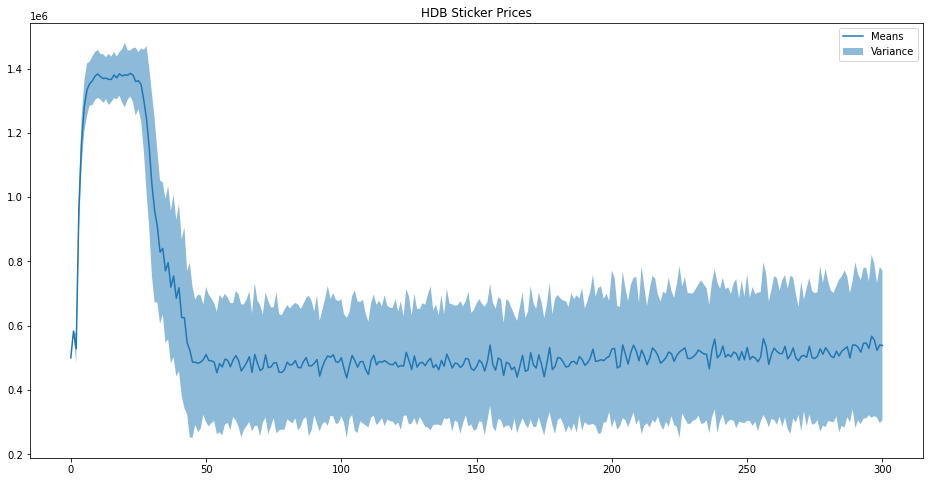

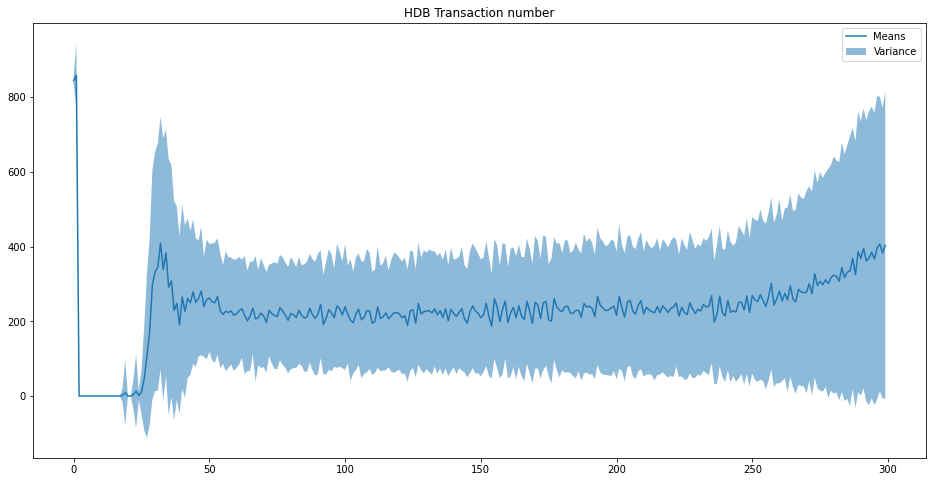

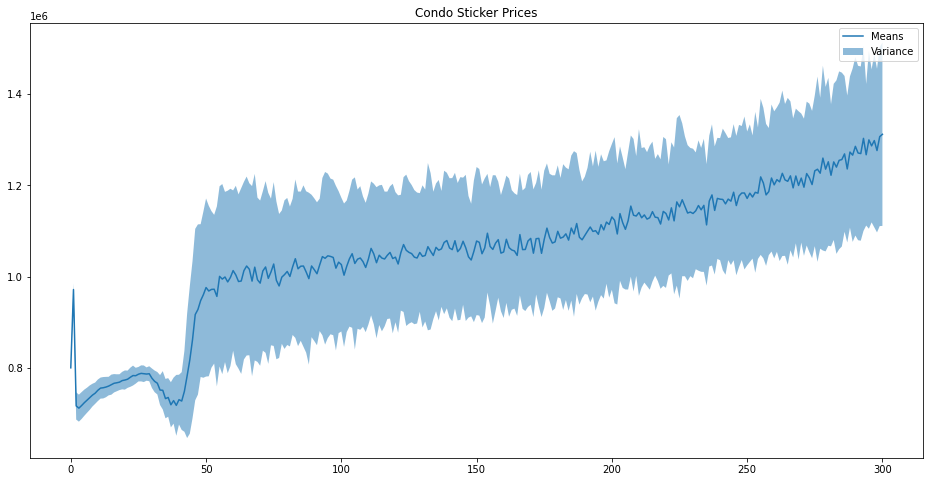

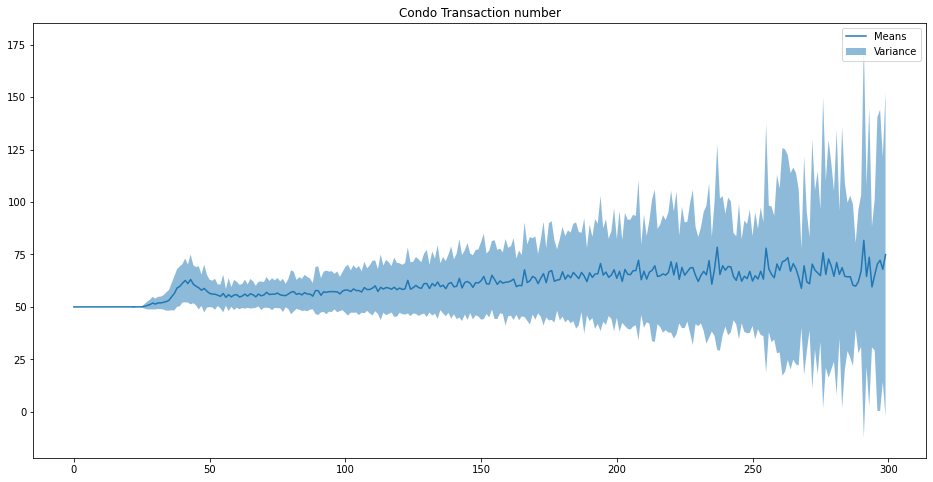

In [15]:
plot_with_error(results,'HDB_price','HDB Sticker Prices')
plot_with_error(results,'HDB_transactions','HDB Transaction number')
plot_with_error(results,'condo_price','Condo Sticker Prices')
plot_with_error(results,'condo_transactions','Condo Transaction number')


Text(0, 0.5, 'Number')

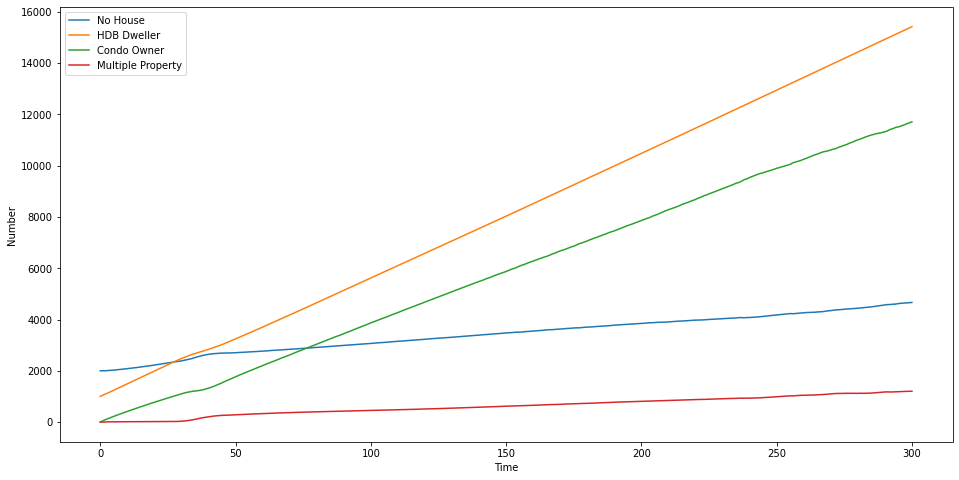

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(np.mean(results['1'],axis=0),label='No House')
plt.plot(np.mean(results['2'],axis=0),label='HDB Dweller')
plt.plot(np.mean(results['3'],axis=0),label='Condo Owner')
plt.plot(np.mean(results['4'],axis=0),label='Multiple Property')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number')

In [19]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(20)
number_condo_func = constant_function(80)
pop_growth_func = constant_function(100)
group_exp_1_more_condo_supply = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)
group_exp_1_more_condo_supply.run_experiments_N_steps_forward(300)

100%|██████████| 100/100 [30:37<00:00, 18.38s/it]


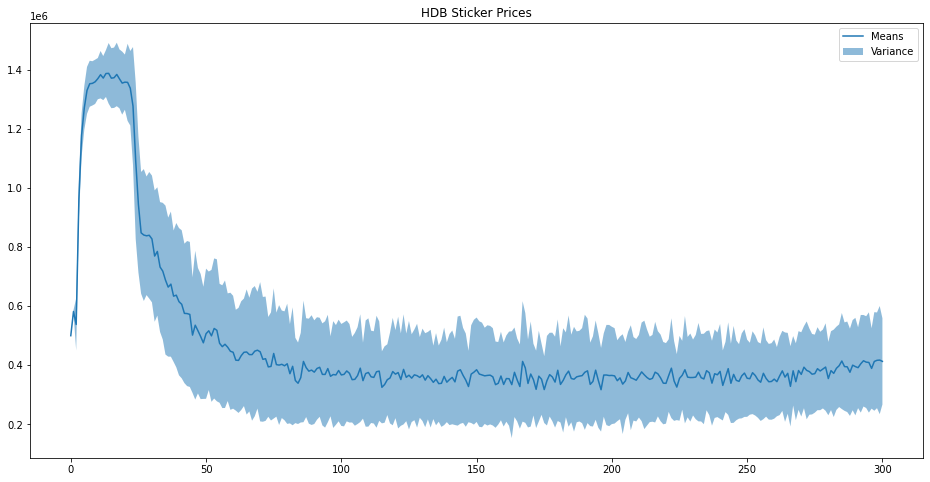

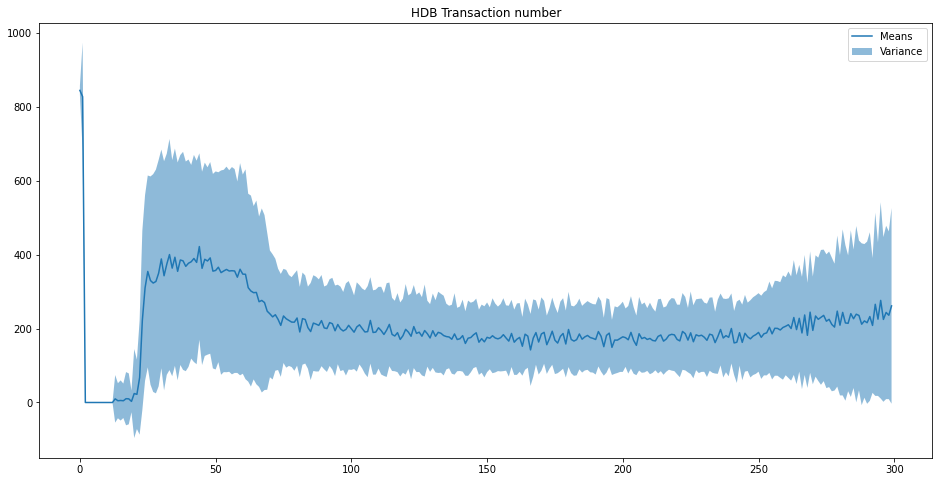

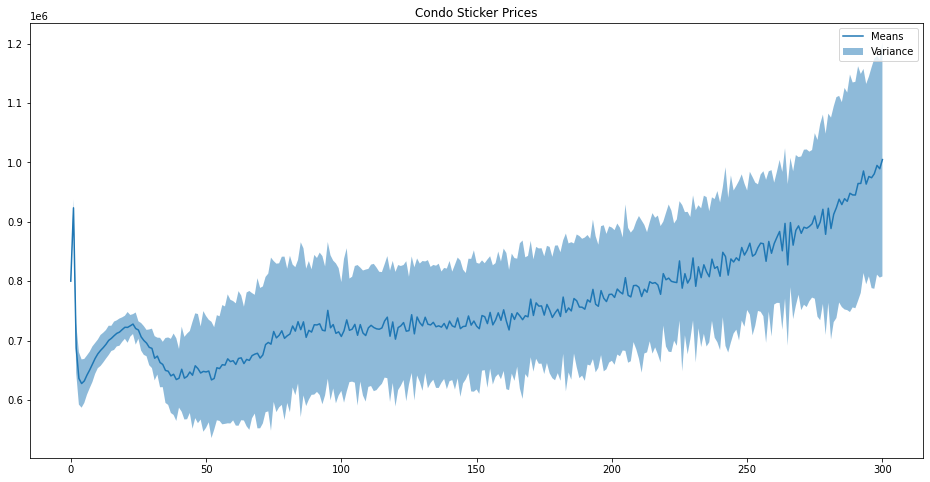

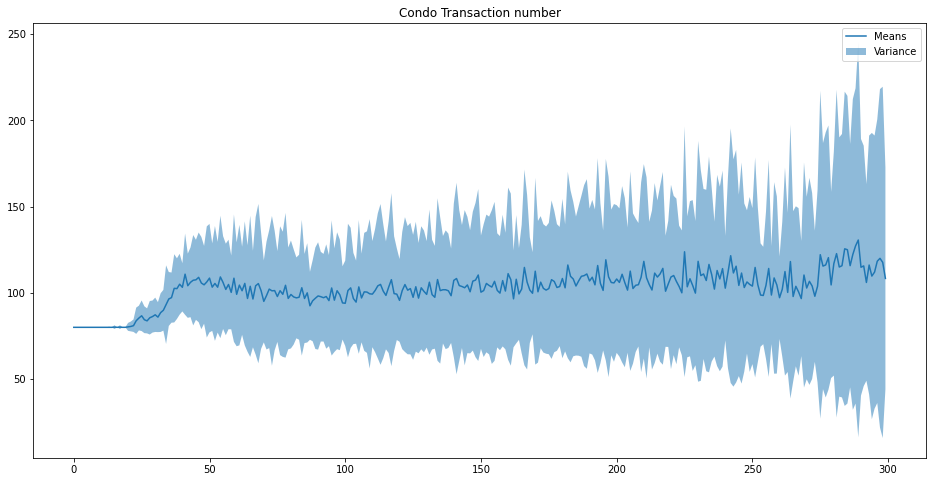

: 

In [28]:
results_more_condo_supply = group_exp_1_more_condo_supply.return_all_results()
save_results_to_file(results_more_condo_supply,'more_condo_supply')
plot_with_error(results_more_condo_supply,'HDB_price','HDB Sticker Prices')
plot_with_error(results_more_condo_supply,'HDB_transactions','HDB Transaction number')
plot_with_error(results_more_condo_supply,'condo_price','Condo Sticker Prices')
plot_with_error(results_more_condo_supply,'condo_transactions','Condo Transaction number')

Text(0, 0.5, 'Number')

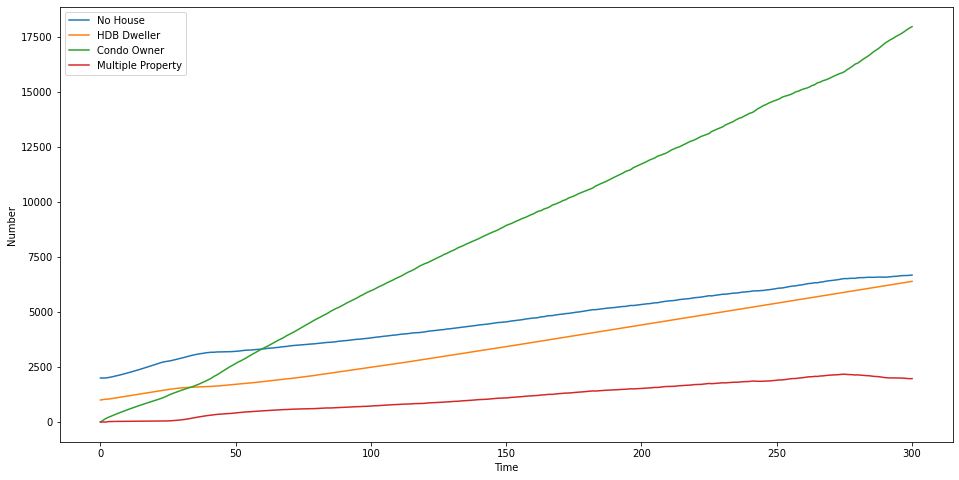

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(np.mean(results_more_condo_supply['1'],axis=0),label='No House')
plt.plot(np.mean(results_more_condo_supply['2'],axis=0),label='HDB Dweller')
plt.plot(np.mean(results_more_condo_supply['3'],axis=0),label='Condo Owner')
plt.plot(np.mean(results_more_condo_supply['4'],axis=0),label='Multiple Property')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number')

In [9]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(80)
number_condo_func = constant_function(20)
pop_growth_func = constant_function(100)
group_exp_1_more_BTO_supply = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)
group_exp_1_more_BTO_supply.run_experiments_N_steps_forward(300)

100%|██████████| 100/100 [21:19<00:00, 12.79s/it]


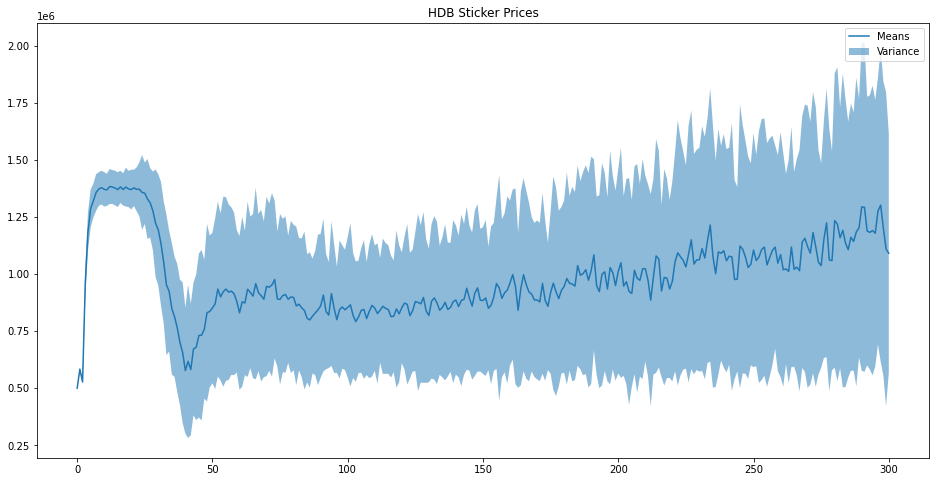

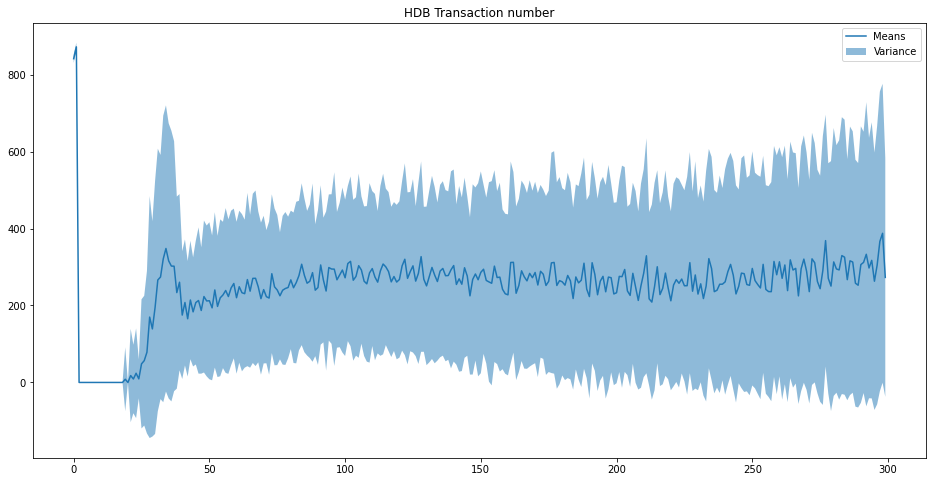

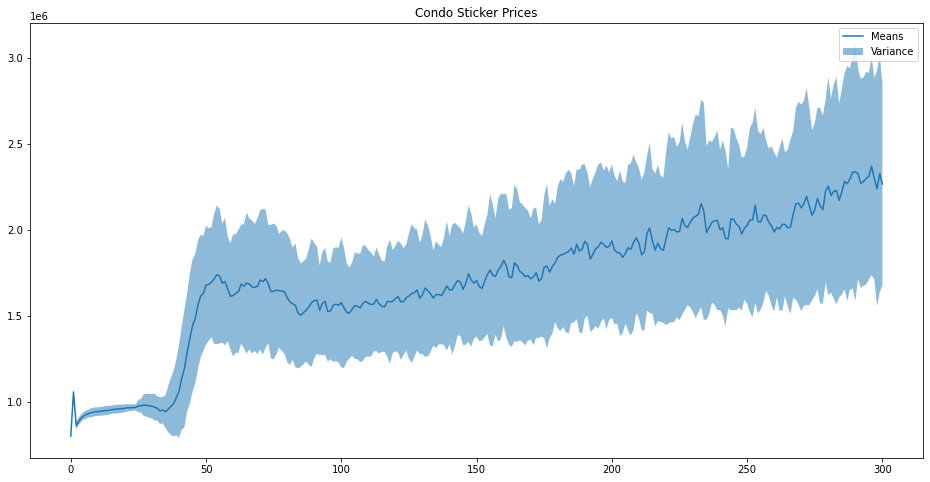

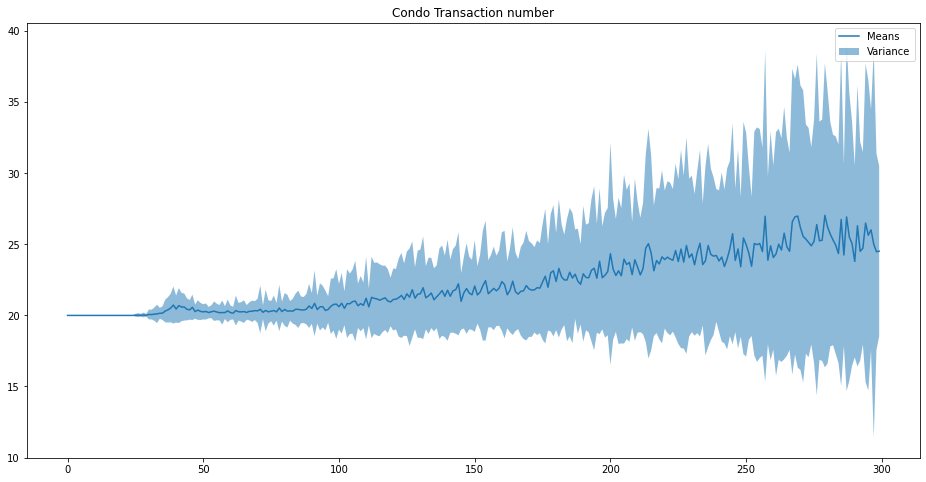

In [10]:
results_more_BTO_supply = group_exp_1_more_BTO_supply.return_all_results()
save_results_to_file(results_more_BTO_supply,'more_BTO_supply')
plot_with_error(results_more_BTO_supply,'HDB_price','HDB Sticker Prices')
plot_with_error(results_more_BTO_supply,'HDB_transactions','HDB Transaction number')
plot_with_error(results_more_BTO_supply,'condo_price','Condo Sticker Prices')
plot_with_error(results_more_BTO_supply,'condo_transactions','Condo Transaction number')

In [3]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(20)
number_condo_func = constant_function(80)
pop_growth_func = constant_function(100)
group_exp_1_more_condo_supply_2 = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)
group_exp_1_more_condo_supply_2.run_experiments_N_steps_forward(300)

100%|██████████| 100/100 [22:41<00:00, 13.61s/it]


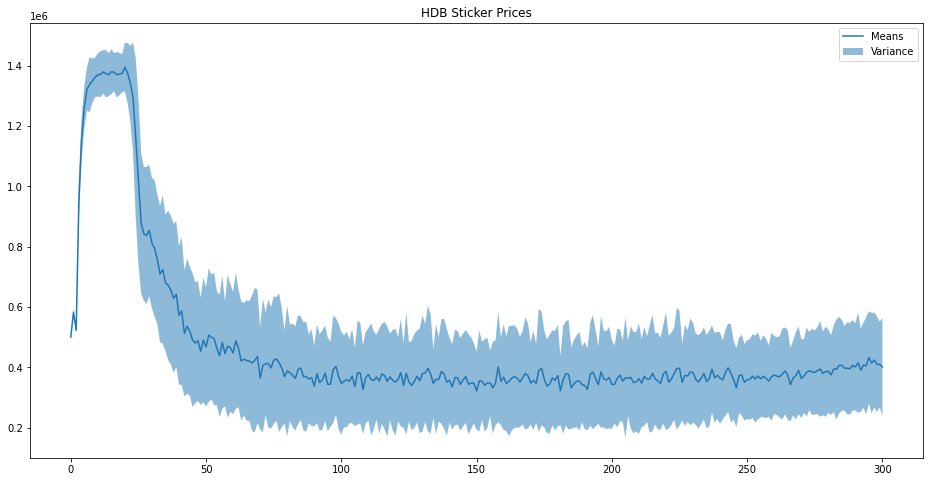

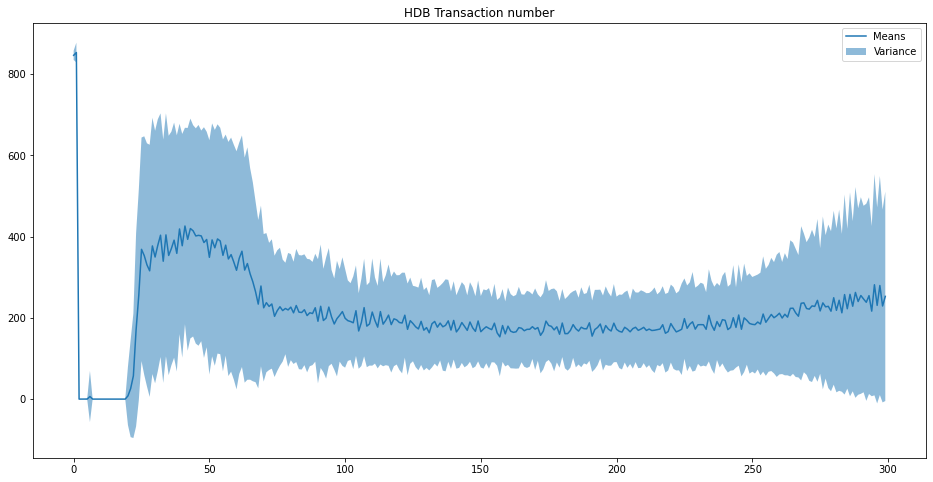

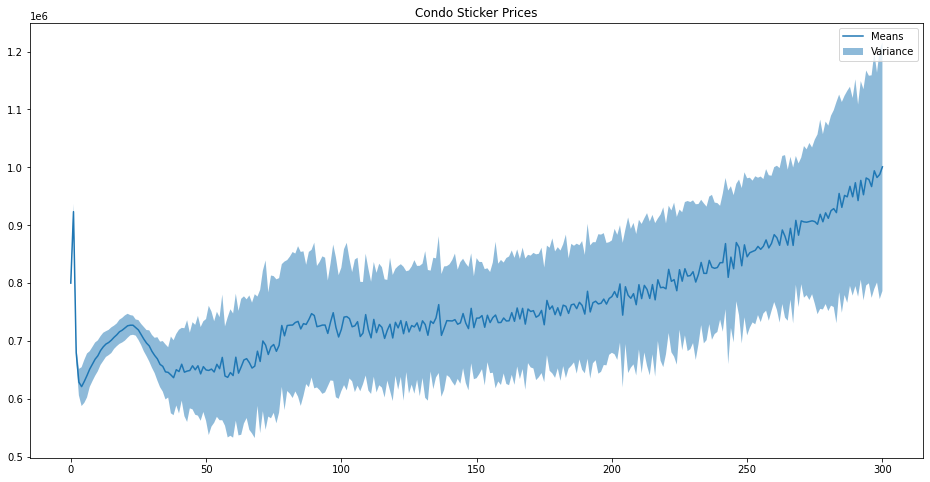

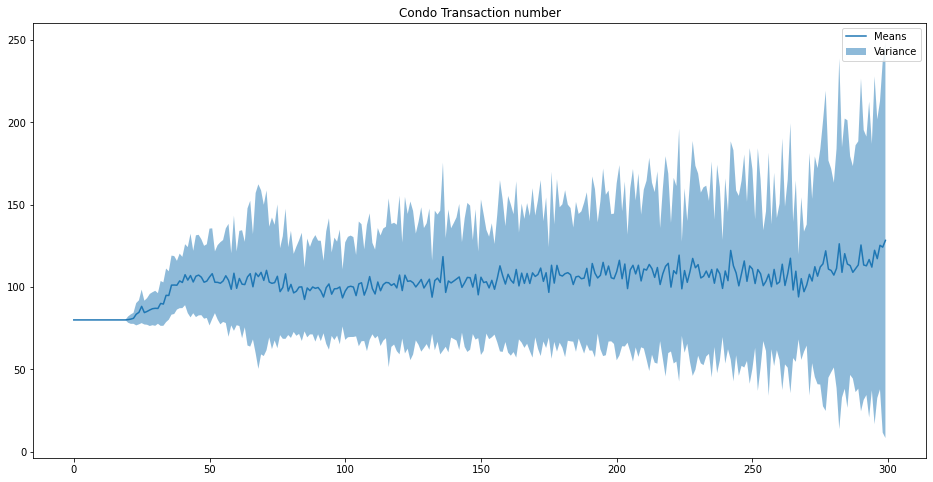

In [5]:
results_more_condo_supply_2 = group_exp_1_more_condo_supply_2.return_all_results()
save_results_to_file(results_more_condo_supply_2,'more_condo_supply_2')
plot_with_error(results_more_condo_supply_2,'HDB_price','HDB Sticker Prices')
plot_with_error(results_more_condo_supply_2,'HDB_transactions','HDB Transaction number')
plot_with_error(results_more_condo_supply_2,'condo_price','Condo Sticker Prices')
plot_with_error(results_more_condo_supply_2,'condo_transactions','Condo Transaction number')

In [11]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(50)
number_condo_func = constant_function(50)
pop_growth_func = constant_function(150)
group_exp_1_equal_supply_more_demand = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)
group_exp_1_equal_supply_more_demand.run_experiments_N_steps_forward(300)
results_equal_supply_more_demand = group_exp_1_equal_supply_more_demand.return_all_results()
save_results_to_file(results_equal_supply_more_demand,'equal_supply_more_demand')

100%|██████████| 100/100 [55:28<00:00, 33.28s/it]


In [12]:
interest_rate_function = constant_function(0.05/12)
HDB_ini_dist_func = create_normal_distribution_function(700000,200000)
condo_ini_dist_func = create_normal_distribution_function(1500000,300000)
income_dist_func = create_normal_distribution_function(4000,2000)
number_BTO_func = constant_function(50)
number_condo_func = constant_function(50)
pop_growth_func = constant_function(50)
group_exp_1_equal_supply_less_demand = group_of_experiments(interest_rate_function,2000,1000,0,0,HDB_ini_dist_func,condo_ini_dist_func,income_dist_func,number_BTO_func,number_condo_func,500000,800000,0,200000,pop_growth_func,100)
group_exp_1_equal_supply_less_demand.run_experiments_N_steps_forward(300)
results_equal_supply_less_demand = group_exp_1_equal_supply_less_demand.return_all_results()
save_results_to_file(results_equal_supply_less_demand,'equal_supply_less_demand')

100%|██████████| 100/100 [23:25<00:00, 14.06s/it]
